# Import Classes

In [1]:
import sys
import os


sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np

import random
import itertools
from sklearn import metrics
from tqdm.auto import tqdm


import torch

from src.utils import confoundSplit, confoundSplitNumbers, confoundSplitDF

from src.NeuralModel import TransformerDataset, NeuralModel



# Load Data

## WLS

In [3]:

df_wls = pd.read_csv("/edata/TRESTLE/testWLS.tsv", sep='\t')

df_wls_label = pd.read_csv("/edata/TRESTLE/WLS-labels.csv")

df_wls_merge = df_wls.merge(df_wls_label, left_on='file', right_on='idtlkbnk', how='inner')

# df_wls_merge.rename(columns={"> 1 sd below mean for normals ages 60-79 (Tombaugh, Kozak, & Rees, 1999) -- normal cutoff = 12+ for 9-12 yrs eductation, 14+ for 13-21 yrs education":
#                              "label",
                             
#                             },
#                     inplace=True
#                    )

# df_wls_merge.loc[df_wls_merge['label'] == 'y','label'] = 'Y'

# condlist = [
#     df_wls_merge['label'] == 'Y',
#     df_wls_merge['label'] == 'N',
#     df_wls_merge['label'].isna()
# ]
# choicelist = [
#     1,
#     0,
#     np.nan
# ]

# df_wls_merge['label'] = np.select(condlist, choicelist)

wls_Conditions = [
    (df_wls_merge['age 2011'] <= 79) & (df_wls_merge['education'] <= 12) & (df_wls_merge['category fluency, scored words named, 2011'] < 12),
    (df_wls_merge['age 2011'] <= 79) & (df_wls_merge['education'] >  12) & (df_wls_merge['category fluency, scored words named, 2011'] < 14),
    (df_wls_merge['age 2011'] >  79) & (df_wls_merge['education'] <= 12) & (df_wls_merge['category fluency, scored words named, 2011'] < 10.5),
    (df_wls_merge['age 2011'] >  79) & (df_wls_merge['education'] >  12) & (df_wls_merge['category fluency, scored words named, 2011'] < 12),
]
wls_Categories = [1, 1, 1, 1]

df_wls_merge['label'] = np.select(wls_Conditions, wls_Categories, default=0)




df_wls_merge = df_wls_merge.loc[df_wls_merge['label'].notna(), :].reset_index(drop=True)

## ADReSS

In [4]:
# df_adress_train = pd.read_csv("/edata/ADReSS-IS2020-data/dataframes/adre_train.csv")

# df_adress_test = pd.read_csv("/edata/ADReSS-IS2020-data/dataframes/adre_test.csv")

# df_adress = pd.concat([df_adress_train, df_adress_test], ignore_index=True)

# df_adress.rename(columns={"sentence": "text"}, inplace=True)

In [5]:

df_adress_dementia = pd.read_csv("/edata/TRESTLE/harmonized-toolkit/transcripts/processed_pitt_dementia.tsv", sep="\t")

df_adress_control = pd.read_csv("/edata/TRESTLE/harmonized-toolkit/transcripts/processed_pitt_control.tsv", sep="\t")


df_adress_dementia['label'] = 1
df_adress_control['label'] = 0

df_adress = pd.concat([df_adress_dementia, df_adress_control]).reset_index(drop=True)

In [6]:
df_wls_merge.groupby('label').size()

label
0    1176
1     184
dtype: int64

In [7]:
df_adress.groupby('label').size()

label
0    243
1    305
dtype: int64

# Use Mixing for Prediction

## Mixing

In [10]:

combination = (0.201, 0.6010000000000001, 0.30100000000000005, 1.0, 4)
ret = confoundSplitNumbers(df0=df_wls_merge, df1=df_adress, 
                            df0_label='label', df1_label='label',

                            p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                            train_test_ratio = combination[4],
                           )

In [11]:
ret

{'n_df0_train_pos': 131,
 'n_df0_test_pos': 53,
 'n_df0_train_neg': 524,
 'n_df0_test_neg': 111,
 'n_df1_train_pos': 169,
 'n_df1_test_pos': 22,
 'n_df1_train_neg': 112,
 'n_df1_test_neg': 47,
 'mix_param_dict': {'p_pos_train_z0': 0.201,
  'p_pos_train_z1': 0.6010000000000001,
  'p_pos_train': 0.3214000000000001,
  'p_pos_test': 0.3214000000000001,
  'p_mix_z0': 0.699,
  'p_mix_z1': 0.30100000000000005,
  'alpha_train': 2.9900497512437814,
  'alpha_test': 1.0,
  'p_pos_test_z0': 0.3214000000000001,
  'p_pos_test_z1': 0.3214000000000001,
  'C_y': 0.3214000000000001,
  'C_z': 0.30100000000000005}}

In [12]:
combination = (0.201, 0.6010000000000001, 0.30100000000000005, 1.0, 4)
ret = confoundSplitDF(df0=df_wls_merge, df1=df_adress, 
                            df0_label='label', df1_label='label',

                            p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                            train_test_ratio = combination[4],
                           )

In [13]:
ret['stats']

{'n_df0_train_pos': 131,
 'n_df0_test_pos': 53,
 'n_df0_train_neg': 524,
 'n_df0_test_neg': 111,
 'n_df1_train_pos': 169,
 'n_df1_test_pos': 22,
 'n_df1_train_neg': 112,
 'n_df1_test_neg': 47,
 'mix_param_dict': {'p_pos_train_z0': 0.201,
  'p_pos_train_z1': 0.6010000000000001,
  'p_pos_train': 0.3214000000000001,
  'p_pos_test': 0.3214000000000001,
  'p_mix_z0': 0.699,
  'p_mix_z1': 0.30100000000000005,
  'alpha_train': 2.9900497512437814,
  'alpha_test': 1.0,
  'p_pos_test_z0': 0.3214000000000001,
  'p_pos_test_z1': 0.3214000000000001,
  'C_y': 0.3214000000000001,
  'C_z': 0.30100000000000005}}

In [11]:
ret

{'sample_df0_train':            file                                               text  \
 0    2000008541  Let's see. A little boy is in the cookie jar s...   
 1    2000009653  The kid's in the cookie jar. The girl wants hi...   
 2    2000013905  He's going to fall off that stool. And she's r...   
 3    2000000208  Boy going in the cookie jar. Girl laughing at ...   
 4    2000015630  Oh. Mother's doing the work. But she's not pay...   
 ..          ...                                                ...   
 650  2000012299  I see a lady doing washing dishes wiping dishe...   
 651  2000015974  Water falling off outof the sink. Chair fallin...   
 652  2000015047  Water overflowing in the sink. Mother drying d...   
 653  2000001600  Um the little girl is telling the little boy n...   
 654  2000015187  Okay. Everything i see. I see a guy standing o...   
 
        idtlkbnk  age 2011  education  category fluency version, 2011  \
 0    2000008541        73         12                

In [12]:
df0_train = ret['sample_df0_train']

## Load Data

In [13]:
# combination = (0.201, 0.6010000000000001, 0.30100000000000005, 1.0, 4)

combination = (0.201, 0.7010000000000001, 0.501, 1.4000000000000001, 4)
ret = confoundSplitDF(df0=df_wls_merge, df1=df_adress, 
                      df0_label='label', df1_label='label',
                      p_pos_train_z0=combination[0], 
                      p_pos_train_z1 = combination[1], 
                      p_mix_z1 = combination[2], 
                      alpha_test = combination[3],
                      train_test_ratio = combination[4],
                      random_state=13
                           )

In [14]:
df_train = pd.concat([ret['sample_df0_train'][['text', 'label']], ret['sample_df1_train'][['text', 'label']]], ignore_index=True)

In [15]:
df_test = pd.concat([ret['sample_df0_test'][['text', 'label']], ret['sample_df1_test'][['text', 'label']]], ignore_index=True)

In [16]:
X_train = df_train['text']
y_train = df_train[['label']]

X_test = df_test['text']
y_test = df_test[['label']]

In [149]:
print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

181
181
44
44


In [17]:
print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

718
718
179
179


## Training -  Test for LR and Epochs..

In [150]:
num_labels = 1

pretrained = 'bert-base-uncased'
device = 'cuda:0'

max_length = 120
num_epochs = 10
problem_type = 'multi_label_classification'
hidden_dropout_prob = 0.1
num_warmup_steps = 0
batch_size = 50


lr = 1e-5
grad_norm = 1.0
balance_weights = False



In [151]:

model_config = {}
# model_config['model_type'] = model_type
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm


In [152]:
model = NeuralModel(**model_config)

In [153]:
model.load_pretrained()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [154]:
model.trainModelWithTest(X=X_train, y=y_train, X_test=X_test, y_test=y_test, device='cuda:0')

  0%|          | 0/40 [00:00<?, ?it/s]

In [142]:
import matplotlib.pyplot as plt

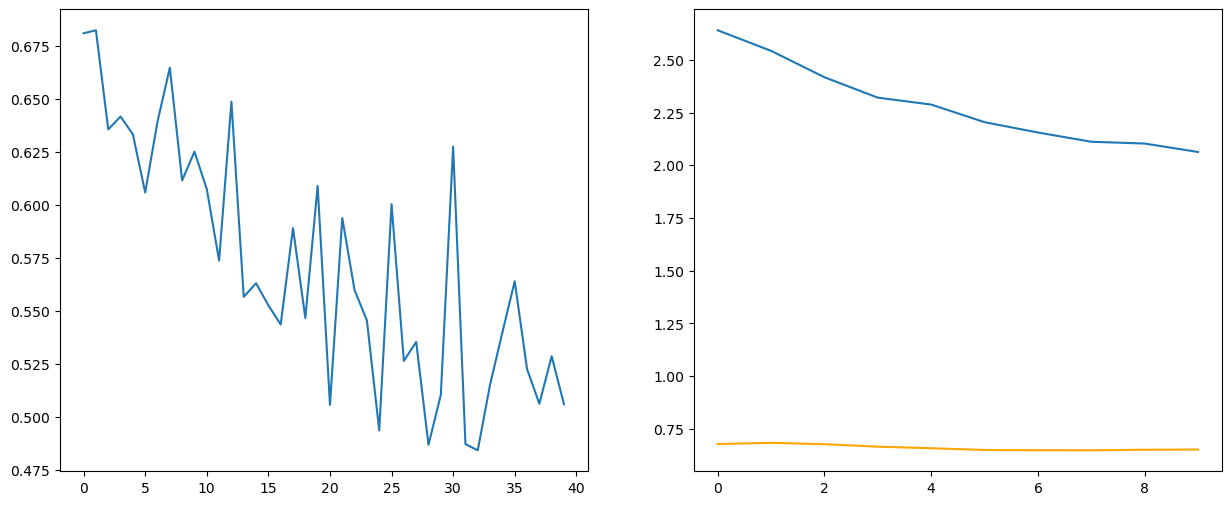

In [155]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

ax[0].plot(model.loss_steps)
ax[1].plot(model.loss_epochs)
ax[1].plot(model.loss_test_epochs, c='orange')


Text(0.5, 1.0, 'epoch=10, lr=1e-05')

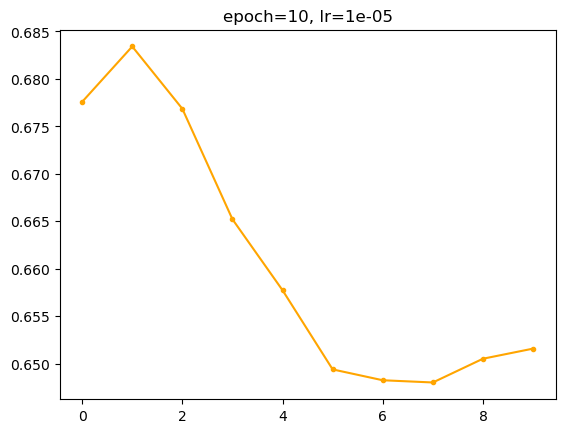

In [156]:
plt.plot(model.loss_test_epochs, c='orange', marker=".")
plt.title(f"epoch={num_epochs}, lr={lr}")

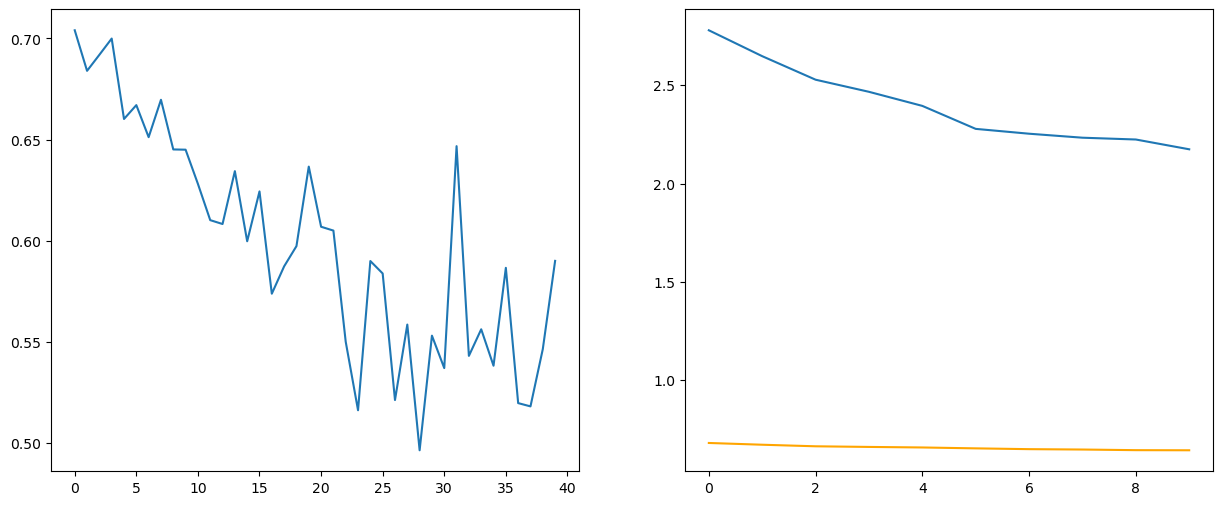

In [143]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

ax[0].plot(model.loss_steps)
ax[1].plot(model.loss_epochs)
ax[1].plot(model.loss_test_epochs, c='orange')


Text(0.5, 1.0, 'epoch=10, lr=1e-05')

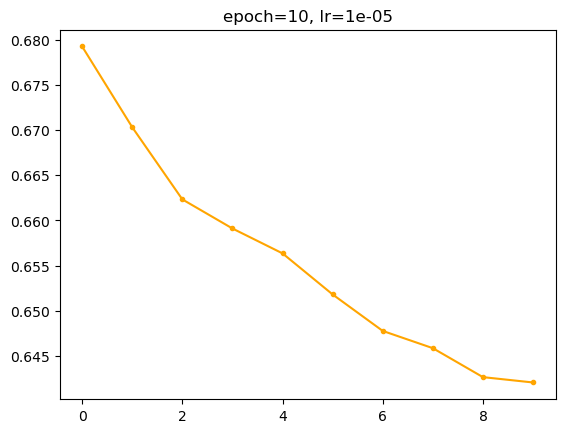

In [144]:
plt.plot(model.loss_test_epochs, c='orange', marker=".")
plt.title(f"epoch={num_epochs}, lr={lr}")

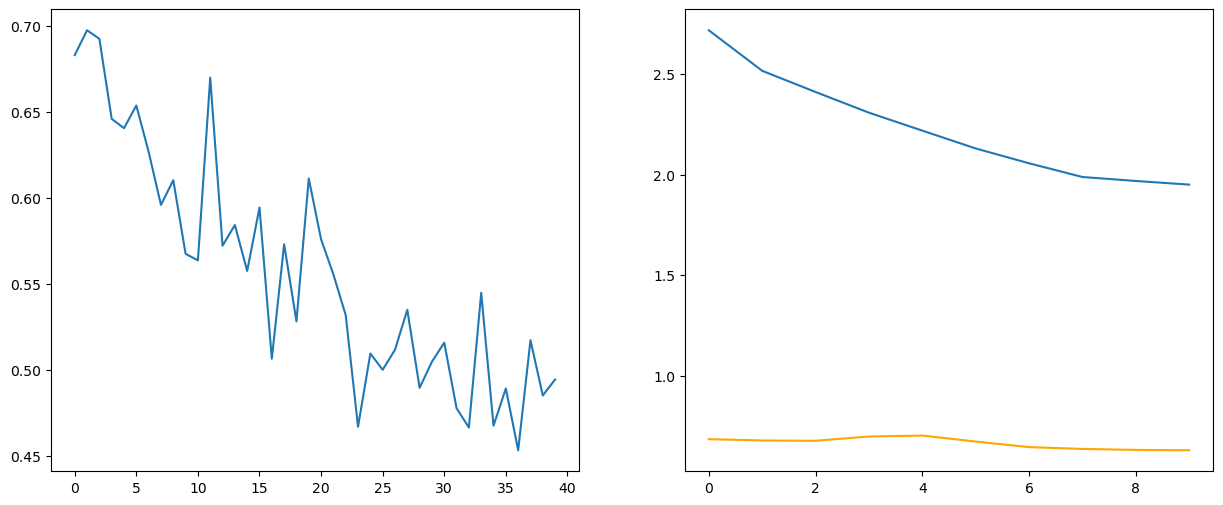

In [130]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

ax[0].plot(model.loss_steps)
ax[1].plot(model.loss_epochs)
ax[1].plot(model.loss_test_epochs, c='orange')


Text(0.5, 1.0, 'epoch=10, lr=1e-05')

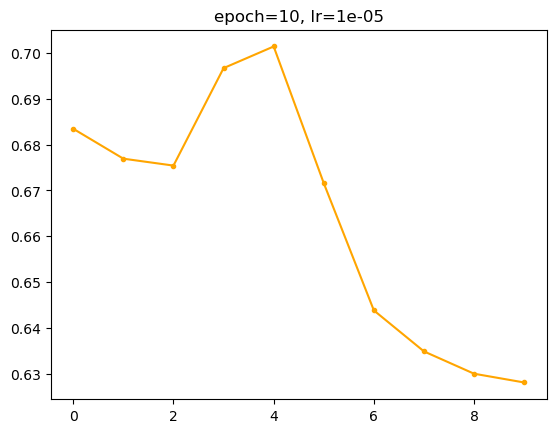

In [131]:
plt.plot(model.loss_test_epochs, c='orange', marker=".")
plt.title(f"epoch={num_epochs}, lr={lr}")

## Training

In [234]:
num_labels = 1

pretrained = 'bert-base-uncased'
device = 'cuda:0'

max_length = 120
num_epochs = 6
problem_type = 'multi_label_classification'
hidden_dropout_prob = 0.1
num_warmup_steps = 0
batch_size = 50


lr = 1e-5
grad_norm = 1.0
balance_weights = False



In [235]:

model_config = {}
# model_config['model_type'] = model_type
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm


In [236]:
model = NeuralModel(**model_config)

In [237]:
model.load_pretrained()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [238]:
model.trainModel(X=X_train, y=y_train,  device='cuda:0')

  0%|          | 0/24 [00:00<?, ?it/s]

## Predict

In [247]:
y_pred, y_prob = model.predict(X=X_test, device="cuda:0")



  0%|          | 0/1 [00:00<?, ?it/s]

In [248]:
loss = torch.nn.BCELoss()

In [249]:
torch.FloatTensor(y_prob.loc[:,0])

tensor([0.3877, 0.3520, 0.3450, 0.3472, 0.3445, 0.3541, 0.3759, 0.3414, 0.3440,
        0.3126, 0.3829, 0.3469, 0.4174, 0.3619, 0.4092, 0.3760, 0.4296, 0.3915,
        0.4377, 0.3969, 0.3794, 0.4115, 0.3527, 0.4753, 0.4670, 0.5518, 0.4585,
        0.5489, 0.5295, 0.5461, 0.4961, 0.4916, 0.5334, 0.5329, 0.5514, 0.4625,
        0.5233, 0.4828, 0.5041, 0.5114, 0.5629, 0.5293, 0.4912, 0.4832])

In [250]:
loss(torch.FloatTensor(y_prob.loc[:,0]), torch.FloatTensor(y_test['label']))

tensor(0.6719)

# Multiple Tests for mixing

## Base Config

In [7]:
num_labels = 1

pretrained = 'bert-base-uncased'
device = 'cuda:0'

max_length = 120
num_epochs = 6
problem_type = 'multi_label_classification'
hidden_dropout_prob = 0.1
num_warmup_steps = 0
batch_size = 50


lr = 1e-5
grad_norm = 1.0
balance_weights = False



In [8]:

model_config = {}
# model_config['model_type'] = model_type
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm


## 5 Random Runs: Train and Predict

### Get Combinations

In [9]:
# itertools.product([0.1], 
#                                     [0.5], 
#                                      np.arange(0.1, 0.999, 0.1),
#                                      np.arange(0,10,0.1),
#                                      [4]
                  
# itertools.product([0.2], 
#                                     [0.4], 
#                                      np.arange(0.1, 0.999, 0.1),
#                                      np.arange(0,10,0.1),
#                                      [4] 

In [245]:
n_test = 100  # the number of testing examples; set to None to disable (i.e., get as many examples as possible)
n_test_error = 0

valid_high_combinations = []
valid_full_settings = []
for combination in itertools.product([0.1], 
                                    [0.5], 
                                     np.arange(0.05, 0.99, 0.05),
                                     np.arange(0, 10, 0.1),
                                     [4],
                                     [n_test],
                                     [n_test_error]
                                    ):
    
    ret = confoundSplitNumbers(df0=df_wls_merge, df1=df_adress, 
                        df0_label='label', df1_label='label',

                        p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                        train_test_ratio = combination[4], 
                               n_test=n_test, n_test_error=n_test_error
                       )
   
    if (ret is not None) and (ret['n_df0_train_pos'] >= 1): # valid high combos
        valid_high_combinations.append(combination)
        valid_full_settings.append(ret)
    

In [246]:
del combination

In [247]:
len(valid_high_combinations)

166

In [248]:
tmp = []
for s in valid_full_settings:
    tmp.append(s['n_df0_test_pos'] + s['n_df0_test_neg']  + s['n_df1_test_pos'] + s['n_df1_test_neg'])

In [249]:
_mix_z1 = [x[2] for x in valid_high_combinations]
print(min(_mix_z1))
print(max(_mix_z1))
print(sorted(set(_mix_z1)))

0.05
0.9000000000000001
[0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.6500000000000001, 0.7000000000000001, 0.7500000000000001, 0.8, 0.9000000000000001]


### Run Train + Predict

In [14]:
losses_dict = {}

losses_dict['combination'] = []
losses_dict['full_setting']=[]
losses_dict['losses'] = []
losses_dict['auroc'] = []
losses_dict['auprc'] = []
losses_dict['f1_at_05'] = []ly one of the most legendary characters in video game history, Mario has conquered a forever place in our hearts! We looked up various places on fan forums and threads and found that there are various different versions of Mario available to play n


random.seed(29)

for c,setting in tqdm(zip(valid_high_combinations, valid_full_settings), total=len(valid_high_combinations)):
    losses_dict['combination'].append(c)
    losses_dict['full_setting'].append(setting)
    
    losses = []
    _auroc = []
    _auprc = []    
    _f1_at_05 = []
    
    for i in range(5):
        _rand = random.randint(0,1000)    

        combination = c
        # combination = (0.201, 0.6, 0.3, 1.0, 4)
        # combination = (0.201, 0.7, 0.5, 1.4, 4)
        ret = confoundSplitDF(df0=df_wls_merge, df1=df_adress, 
                              df0_label='label', df1_label='label',
                              p_pos_train_z0=combination[0], 
                              p_pos_train_z1 = combination[1], 
                              p_mix_z1 = combination[2], 
                              alpha_test = combination[3],
                              train_test_ratio = combination[4],
                              random_state= _rand,
                              n_test=combination[5],
                              n_test_error=combination[6]
                                   )

        df_train = pd.concat([ret['sample_df0_train'][['text', 'label']], ret['sample_df1_train'][['text', 'label']]], ignore_index=True)

        df_test = pd.concat([ret['sample_df0_test'][['text', 'label']], ret['sample_df1_test'][['text', 'label']]], ignore_index=True)



        X_train = df_train['text']
        y_train = df_train[['label']]

        X_test = df_test['text']
        y_test = df_test[['label']]



        model = NeuralModel(**model_config)

        model.load_pretrained()

        model.trainModel(X=X_train, y=y_train,  device='cuda:0')



        y_pred, y_prob = model.predict(X=X_test, device="cuda:0")

        

        loss = torch.nn.BCELoss()

        _loss = loss(torch.FloatTensor(y_prob.loc[:,0]), torch.FloatTensor(y_test['label']))

        losses.append(_loss.item())
        
        _auroc.append(metrics.roc_auc_score(y_true=y_test['label'], y_score=y_prob))
        _auprc.append(metrics.average_precision_score(y_true=y_test['label'], y_score=y_prob))
        _f1_at_05.append(metrics.f1_score(y_true=y_test['label'], y_pred=y_pred))
    
    losses_dict['losses'].append(losses)
    losses_dict['auroc'].append(_auroc)
    losses_dict['auprc'].append(_auprc)
    losses_dict['f1_at_05'].append(_f1_at_05)
    

  0%|          | 0/74 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

KeyboardInterrupt: 

## Output Results

In [ ]:
import pickle

In [ ]:
with open("../output/results_varying_alpha_0.pkl", "wb") as f:
    pickle.dump(obj=losses_dict, file=f)

In [ ]:
!ls -lrt output

# Results & Make Plots

## Collect from Pickles

In [17]:
import pickle
import numpy as np
import pandas as pd

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
losses_ls = []

for i in ["../output/step101_runExp/exp_01_05/results.pkl",
          "../output/step101_runExp/exp_02_04/results.pkl",
          "../output/step101_runExp/exp_03_06/results.pkl",
         ]:
    with open(i, "rb") as f:
        _ = pickle.load(f)
    losses_ls.append(_)


In [20]:
_.keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [21]:
losses_dict = {}

losses_dict['combination'] = []
losses_dict['losses'] = []

for _dict in losses_ls:
    losses_dict['combination'].extend(_dict['combination'])
    losses_dict['losses'].extend(_dict['losses'])

In [8]:
# with open("output/results_varying_alpha_0.pkl", "rb") as f:
#     losses_0 = pickle.load(f)

# with open("output/results_varying_alpha_1.pkl", "rb") as f:
#     losses_1 = pickle.load(f)

# with open("output/results_varying_alpha_2.pkl", "rb") as f:
#     losses_2 = pickle.load(f)

# losses_dict = {}

# losses_dict['combination'] = []
# losses_dict['losses'] = []

# for _dict in (losses_0, losses_1, losses_2):
#     losses_dict['combination'].extend(_dict['combination'])
#     losses_dict['losses'].extend(_dict['losses'])

In [40]:
losses_dict.keys()

dict_keys(['combination', 'losses'])

## Plots

In [43]:
def getTestPos(c, z):
    ret = confoundSplitNumbers(df0=df_wls_merge, df1=df_adress, 
                            df0_label='label', df1_label='label',

                            p_pos_train_z0=c[0], p_pos_train_z1 = c[1], p_mix_z1 = c[2], alpha_test = c[3],

                            train_test_ratio = c[4],
                           )
    if z == "z0":
        
        return ret['mix_param_dict']['p_pos_test_z0']
    elif z == "z1":
        return ret['mix_param_dict']['p_pos_test_z1']

In [44]:
def plotAlphaPmix(losses, alpha_train, key_metric:['auroc', 'auprc','losses','f1_at_05']):
    
    

    tmp = pd.DataFrame.from_dict({c:losses[key_metric][idx] for idx,c in enumerate(losses['combination'])},
                                 orient="index"
                                )

    tmp = tmp.reset_index()

    tmp = pd.melt(tmp, id_vars="index", value_vars=[0,1,2,3,4])

    tmp = tmp.assign(p_mix_z1=np.array(list(tmp['index']))[:,2], alpha_test=np.array(list(tmp['index']))[:,3])

    tmp['p_pos_test_z0'] = tmp['index'].apply(lambda x: getTestPos(x,z="z0"))
    tmp['p_pos_test_z1'] = tmp['index'].apply(lambda x: getTestPos(x,z="z1"))




    plt.figure(figsize=(12,10))

    g = sns.FacetGrid(tmp, col="p_mix_z1", col_wrap=3)

    g.map_dataframe(sns.lineplot, x="alpha_test", y="value")

    g.map(plt.axvline, x=alpha_train, ls='--', c='red', linewidth=1)

    g.set(ylabel=key_metric)
    
    return tmp

In [45]:
def plotAlphaDiffPmix(losses, alpha_diff_train, key_metric:['auroc', 'auprc','losses','f1_at_05']):
    
    

    tmp = pd.DataFrame.from_dict({c:losses[key_metric][idx] for idx,c in enumerate(losses['combination'])},
                                 orient="index"
                                )

    tmp = tmp.reset_index()

    tmp = pd.melt(tmp, id_vars="index", value_vars=[0,1,2,3,4])

    tmp = tmp.assign(p_mix_z1=np.array(list(tmp['index']))[:,2], alpha_test=np.array(list(tmp['index']))[:,3])

    tmp['p_pos_test_z0'] = tmp['index'].apply(lambda x: getTestPos(x,z="z0"))
    tmp['p_pos_test_z1'] = tmp['index'].apply(lambda x: getTestPos(x,z="z1"))

    tmp['p_test_diff'] = tmp['p_pos_test_z1'] - tmp['p_pos_test_z0']



    plt.figure(figsize=(12,10))

    g = sns.FacetGrid(tmp, col="p_mix_z1", col_wrap=3)

    g.map_dataframe(sns.lineplot, x="p_test_diff", y="value")

    g.map(plt.axvline, x=alpha_diff_train, ls='--', c='red', linewidth=1)

    g.set(ylabel=key_metric)

    return tmp

In [46]:
losses_ls[0].keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [48]:
losses_ls[0]['combination'][:2]

[(0.1, 0.5, 0.1, 1.5, 4, 150, 0), (0.1, 0.5, 0.1, 1.6, 4, 150, 0)]

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1
0,"(0.1, 0.5, 0.1, 1.5, 4, 150, 0)",0,0.399078,0.1,1.5,0.133333,0.200000
1,"(0.1, 0.5, 0.1, 1.6, 4, 150, 0)",0,0.400526,0.1,1.6,0.132075,0.211321
2,"(0.1, 0.5, 0.1, 2.2, 4, 150, 0)",0,0.396643,0.1,2.2,0.125000,0.275000
3,"(0.1, 0.5, 0.1, 2.9000000000000004, 4, 150, 0)",0,0.401462,0.1,2.9,0.117647,0.341176
4,"(0.1, 0.5, 0.1, 3.6, 4, 150, 0)",0,0.397046,0.1,3.6,0.111111,0.400000
...,...,...,...,...,...,...,...
340,"(0.1, 0.5, 0.5, 4.7, 4, 150, 0)",4,0.514246,0.5,4.7,0.105263,0.494737
341,"(0.1, 0.5, 0.5, 6.5, 4, 150, 0)",4,0.505288,0.5,6.5,0.080000,0.520000
342,"(0.1, 0.5, 0.5, 6.6000000000000005, 4, 150, 0)",4,0.531488,0.5,6.6,0.078947,0.521053
343,"(0.1, 0.5, 0.5, 8.0, 4, 150, 0)",4,0.512083,0.5,8.0,0.066667,0.533333


<Figure size 1200x1000 with 0 Axes>

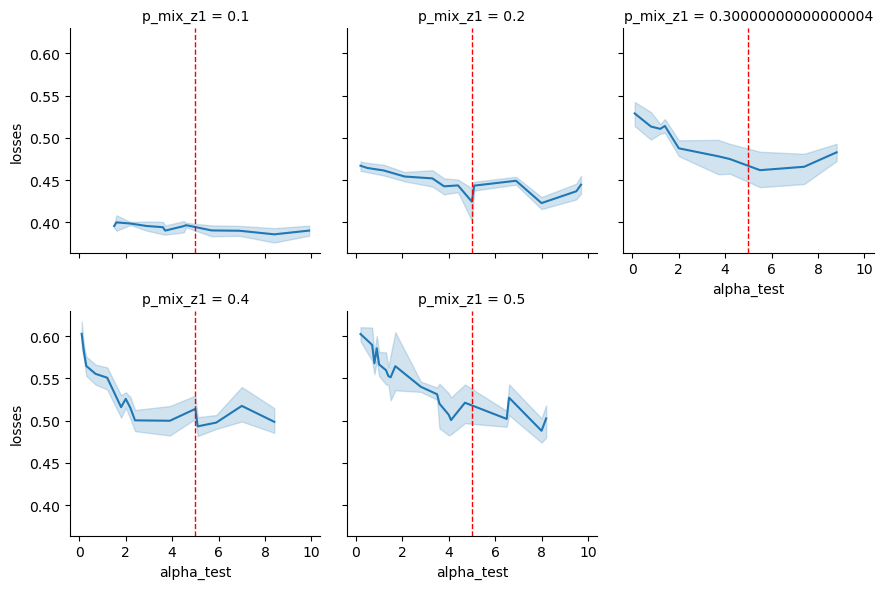

In [50]:
plotAlphaPmix(losses=losses_ls[0], alpha_train=5, key_metric='losses')

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1
0,"(0.1, 0.5, 0.1, 1.5, 4, 150, 0)",0,0.664083,0.1,1.5,0.133333,0.200000
1,"(0.1, 0.5, 0.1, 1.6, 4, 150, 0)",0,0.637505,0.1,1.6,0.132075,0.211321
2,"(0.1, 0.5, 0.1, 2.2, 4, 150, 0)",0,0.658176,0.1,2.2,0.125000,0.275000
3,"(0.1, 0.5, 0.1, 2.9000000000000004, 4, 150, 0)",0,0.600591,0.1,2.9,0.117647,0.341176
4,"(0.1, 0.5, 0.1, 3.6, 4, 150, 0)",0,0.639719,0.1,3.6,0.111111,0.400000
...,...,...,...,...,...,...,...
340,"(0.1, 0.5, 0.5, 4.7, 4, 150, 0)",4,0.828360,0.5,4.7,0.105263,0.494737
341,"(0.1, 0.5, 0.5, 6.5, 4, 150, 0)",4,0.826455,0.5,6.5,0.080000,0.520000
342,"(0.1, 0.5, 0.5, 6.6000000000000005, 4, 150, 0)",4,0.761270,0.5,6.6,0.078947,0.521053
343,"(0.1, 0.5, 0.5, 8.0, 4, 150, 0)",4,0.777566,0.5,8.0,0.066667,0.533333


<Figure size 1200x1000 with 0 Axes>

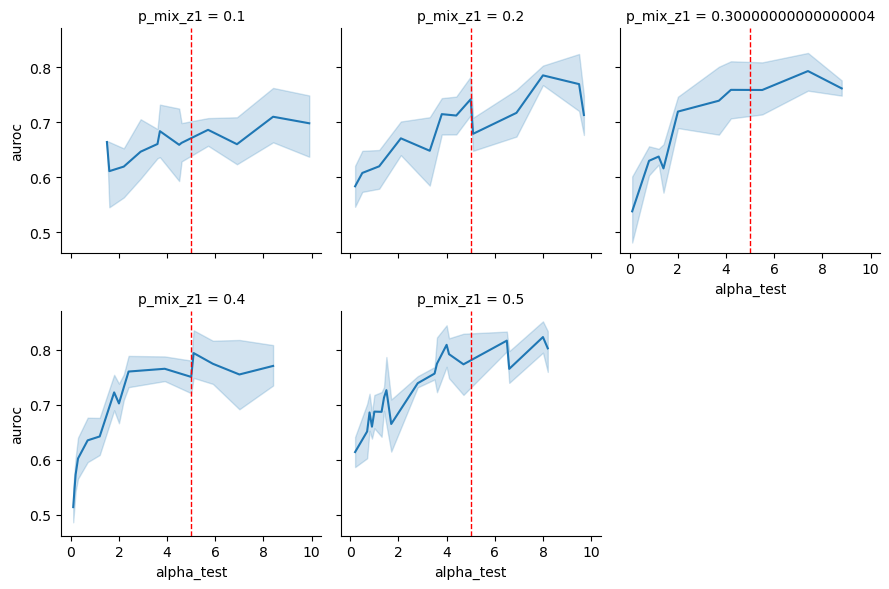

In [66]:
plotAlphaPmix(losses=losses_ls[0], alpha_train=5, key_metric='auroc')

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1
0,"(0.2, 0.4, 0.1, 0.4, 4, 150, 0)",0,0.496250,0.1,0.4,0.234043,0.093617
1,"(0.2, 0.4, 0.1, 0.7000000000000001, 4, 150, 0)",0,0.508843,0.1,0.7,0.226804,0.158763
2,"(0.2, 0.4, 0.1, 1.0, 4, 150, 0)",0,0.518619,0.1,1.0,0.220000,0.220000
3,"(0.2, 0.4, 0.1, 1.7000000000000002, 4, 150, 0)",0,0.504395,0.1,1.7,0.205607,0.349533
4,"(0.2, 0.4, 0.1, 2.0, 4, 150, 0)",0,0.515462,0.1,2.0,0.200000,0.400000
...,...,...,...,...,...,...,...
365,"(0.2, 0.4, 0.5, 3.6, 4, 150, 0)",4,0.479466,0.5,3.6,0.130435,0.469565
366,"(0.2, 0.4, 0.5, 4.1000000000000005, 4, 150, 0)",4,0.527156,0.5,4.1,0.117647,0.482353
367,"(0.2, 0.4, 0.5, 4.7, 4, 150, 0)",4,0.510174,0.5,4.7,0.105263,0.494737
368,"(0.2, 0.4, 0.5, 6.7, 4, 150, 0)",4,0.509381,0.5,6.7,0.077922,0.522078


<Figure size 1200x1000 with 0 Axes>

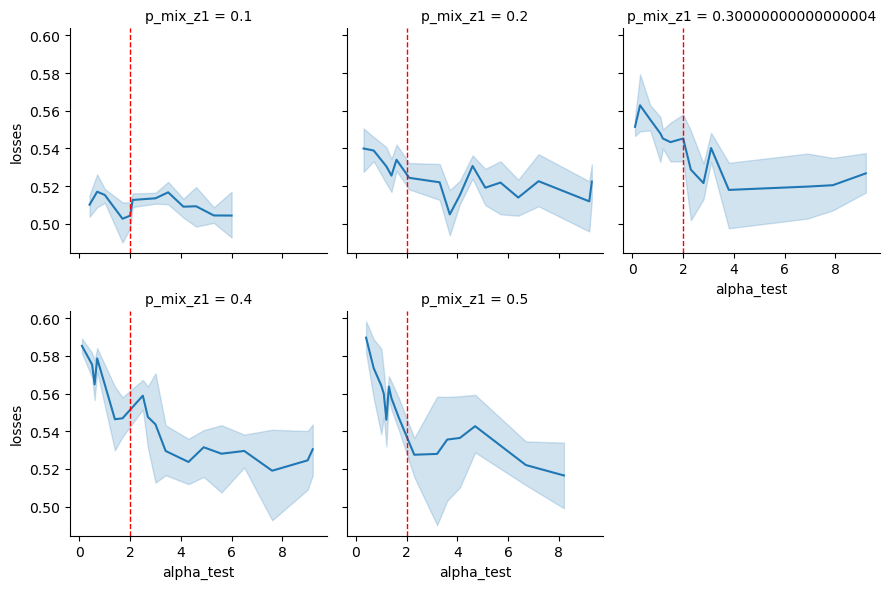

In [67]:
plotAlphaPmix(losses=losses_ls[1], alpha_train=2, key_metric='losses')

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1
0,"(0.2, 0.4, 0.1, 0.4, 4, 150, 0)",0,0.393372,0.1,0.4,0.234043,0.093617
1,"(0.2, 0.4, 0.1, 0.7000000000000001, 4, 150, 0)",0,0.393250,0.1,0.7,0.226804,0.158763
2,"(0.2, 0.4, 0.1, 1.0, 4, 150, 0)",0,0.328838,0.1,1.0,0.220000,0.220000
3,"(0.2, 0.4, 0.1, 1.7000000000000002, 4, 150, 0)",0,0.369092,0.1,1.7,0.205607,0.349533
4,"(0.2, 0.4, 0.1, 2.0, 4, 150, 0)",0,0.327496,0.1,2.0,0.200000,0.400000
...,...,...,...,...,...,...,...
365,"(0.2, 0.4, 0.5, 3.6, 4, 150, 0)",4,0.710513,0.5,3.6,0.130435,0.469565
366,"(0.2, 0.4, 0.5, 4.1000000000000005, 4, 150, 0)",4,0.654542,0.5,4.1,0.117647,0.482353
367,"(0.2, 0.4, 0.5, 4.7, 4, 150, 0)",4,0.692353,0.5,4.7,0.105263,0.494737
368,"(0.2, 0.4, 0.5, 6.7, 4, 150, 0)",4,0.887013,0.5,6.7,0.077922,0.522078


<Figure size 1200x1000 with 0 Axes>

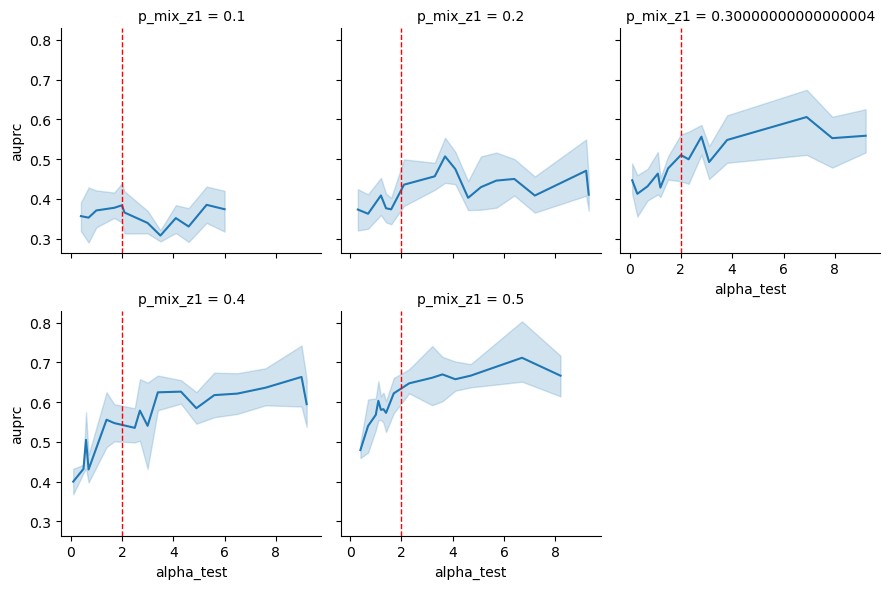

In [52]:
plotAlphaPmix(losses=losses_ls[1], alpha_train=2, key_metric='auprc')

<Figure size 1200x1000 with 0 Axes>

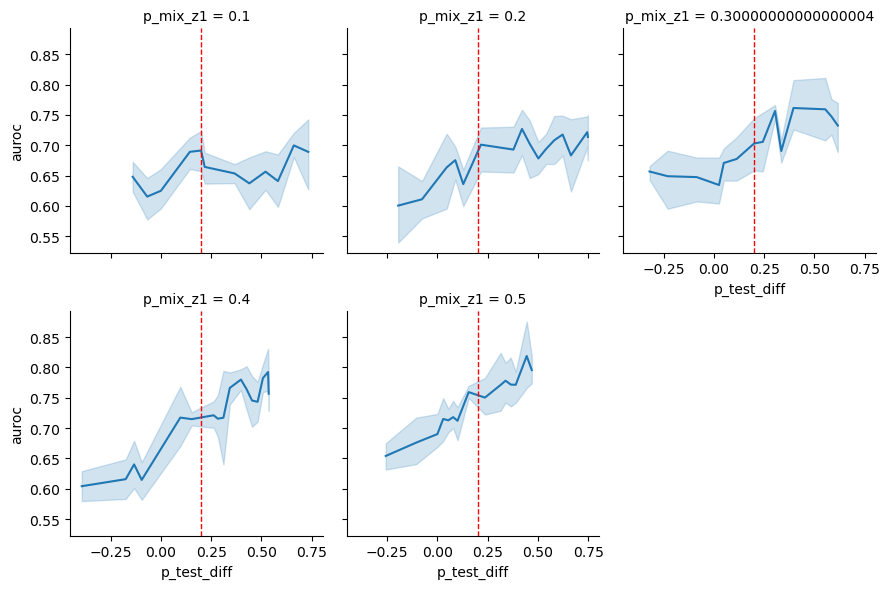

In [53]:
tmp = plotAlphaDiffPmix(losses=losses_ls[1], alpha_diff_train=0.2, key_metric="auroc")

In [54]:
tmp.query("(variable == 0) and (alpha_test == 3)")

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1,p_test_diff
6,"(0.2, 0.4, 0.1, 3.0, 4, 150, 0)",0,0.647242,0.1,3.0,0.183333,0.550000,0.366667
50,"(0.2, 0.4, 0.4, 3.0, 4, 150, 0)",0,0.690476,0.4,3.0,0.155556,0.466667,0.311111


Text(0, 0.5, 'p_pos_test')

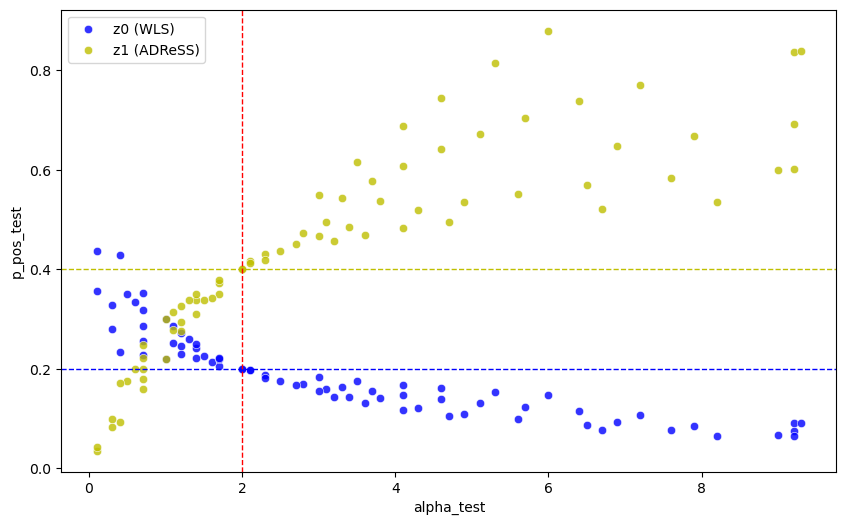

In [56]:
fig, ax = plt.subplots(figsize=(10,6))


sns.scatterplot(x="alpha_test", y="p_pos_test_z0", data=tmp[tmp['variable']==0], color="b", ax=ax, label="z0 (WLS)", alpha=0.8)
sns.scatterplot(x="alpha_test", y="p_pos_test_z1", data=tmp[tmp['variable']==0], color="y", ax=ax, label="z1 (ADReSS)", alpha=0.8)

ax.axhline(y=0.2, c="b", ls="--", linewidth=1)
ax.axhline(y=0.4, c="y", ls="--", linewidth=1)

ax.axvline(x=2, c="r", ls="--", linewidth=1)

ax.set_ylabel("p_pos_test")

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1
0,"(0.3, 0.6, 0.2, 1.4000000000000001, 4, 150, 0)",0,0.627622,0.2,1.4,0.333333,0.466667
1,"(0.3, 0.6, 0.2, 1.6, 4, 150, 0)",0,0.619494,0.2,1.6,0.321429,0.514286
2,"(0.3, 0.6, 0.2, 1.9000000000000001, 4, 150, 0)",0,0.608464,0.2,1.9,0.305085,0.579661
3,"(0.3, 0.6, 0.2, 2.0, 4, 150, 0)",0,0.625250,0.2,2.0,0.300000,0.600000
4,"(0.3, 0.6, 0.2, 2.6, 4, 150, 0)",0,0.613280,0.2,2.6,0.272727,0.709091
...,...,...,...,...,...,...,...
325,"(0.3, 0.6, 0.5, 4.7, 4, 150, 0)",4,0.585860,0.5,4.7,0.157895,0.742105
326,"(0.3, 0.6, 0.5, 5.9, 4, 150, 0)",4,0.581876,0.5,5.9,0.130435,0.769565
327,"(0.3, 0.6, 0.5, 6.6000000000000005, 4, 150, 0)",4,0.573532,0.5,6.6,0.118421,0.781579
328,"(0.3, 0.6, 0.5, 7.6000000000000005, 4, 150, 0)",4,0.601986,0.5,7.6,0.104651,0.795349


<Figure size 1200x1000 with 0 Axes>

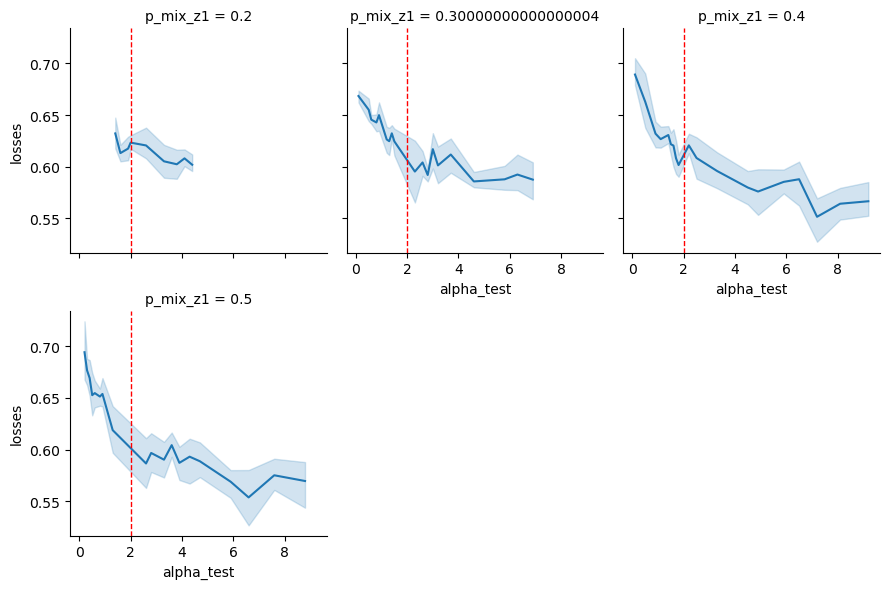

In [69]:
plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='losses')

In [62]:
ct_train = []
ct_test = []
for s in losses_ls[0]['full_setting']:
    ct_train.append(s['n_df0_train_pos'] + s['n_df0_train_neg']+s['n_df1_train_pos']+s['n_df1_train_neg'])
    ct_test.append(s['n_df0_test_pos']+ s['n_df0_test_neg']+s['n_df1_test_pos']+s['n_df1_test_neg'])
    

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1
0,"(0.2, 0.4, 0.1, 0.4, 4, 150, 0)",0,0.393372,0.1,0.4,0.234043,0.093617
1,"(0.2, 0.4, 0.1, 0.7000000000000001, 4, 150, 0)",0,0.393250,0.1,0.7,0.226804,0.158763
2,"(0.2, 0.4, 0.1, 1.0, 4, 150, 0)",0,0.328838,0.1,1.0,0.220000,0.220000
3,"(0.2, 0.4, 0.1, 1.7000000000000002, 4, 150, 0)",0,0.369092,0.1,1.7,0.205607,0.349533
4,"(0.2, 0.4, 0.1, 2.0, 4, 150, 0)",0,0.327496,0.1,2.0,0.200000,0.400000
...,...,...,...,...,...,...,...
365,"(0.2, 0.4, 0.5, 3.6, 4, 150, 0)",4,0.710513,0.5,3.6,0.130435,0.469565
366,"(0.2, 0.4, 0.5, 4.1000000000000005, 4, 150, 0)",4,0.654542,0.5,4.1,0.117647,0.482353
367,"(0.2, 0.4, 0.5, 4.7, 4, 150, 0)",4,0.692353,0.5,4.7,0.105263,0.494737
368,"(0.2, 0.4, 0.5, 6.7, 4, 150, 0)",4,0.887013,0.5,6.7,0.077922,0.522078


<Figure size 1200x1000 with 0 Axes>

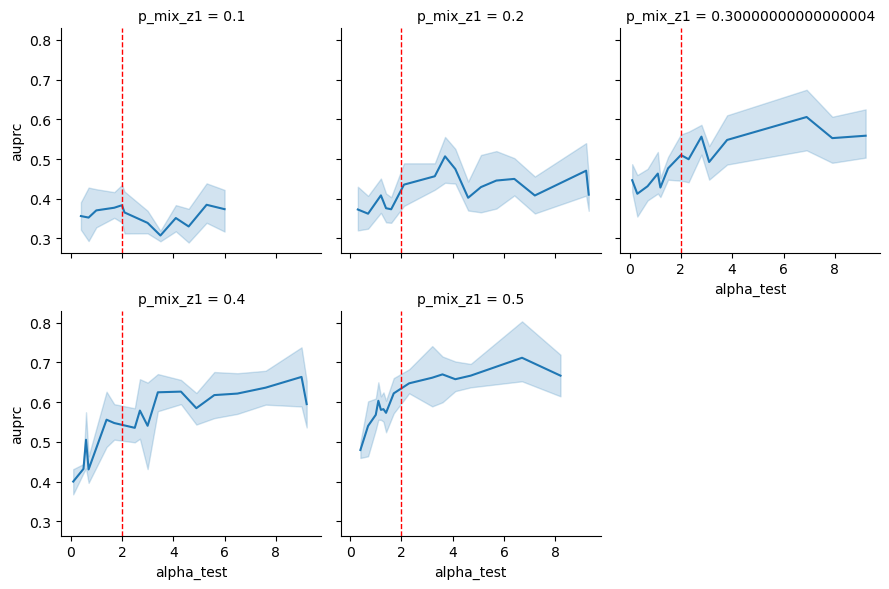

In [70]:
plotAlphaPmix(losses=losses_ls[1], alpha_train=2, key_metric='auprc')

<Figure size 1200x1000 with 0 Axes>

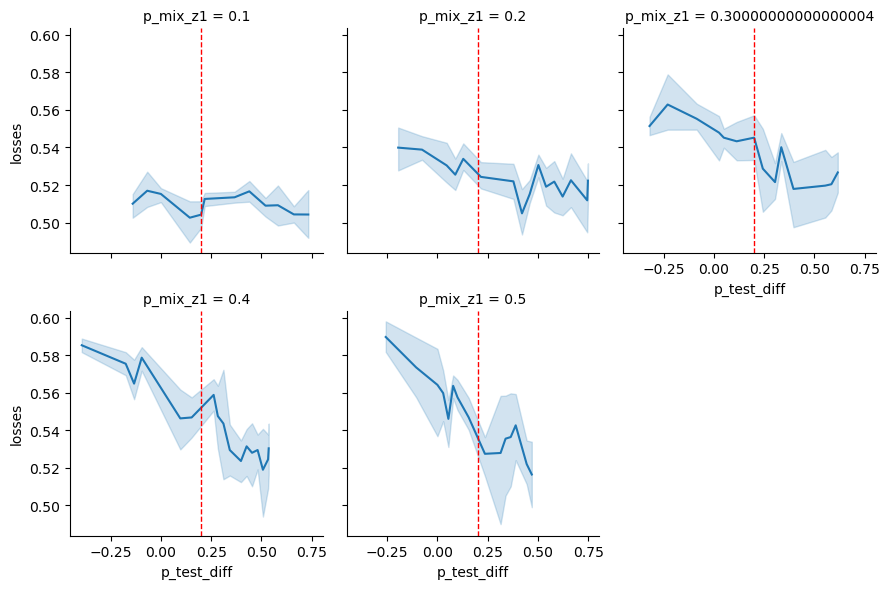

In [71]:
tmp = plotAlphaDiffPmix(losses=losses_ls[1], alpha_diff_train=0.2, key_metric="losses")

In [72]:
tmp

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1,p_test_diff
0,"(0.2, 0.4, 0.1, 0.4, 4, 150, 0)",0,0.496250,0.1,0.4,0.234043,0.093617,-0.140426
1,"(0.2, 0.4, 0.1, 0.7000000000000001, 4, 150, 0)",0,0.508843,0.1,0.7,0.226804,0.158763,-0.068041
2,"(0.2, 0.4, 0.1, 1.0, 4, 150, 0)",0,0.518619,0.1,1.0,0.220000,0.220000,0.000000
3,"(0.2, 0.4, 0.1, 1.7000000000000002, 4, 150, 0)",0,0.504395,0.1,1.7,0.205607,0.349533,0.143925
4,"(0.2, 0.4, 0.1, 2.0, 4, 150, 0)",0,0.515462,0.1,2.0,0.200000,0.400000,0.200000
...,...,...,...,...,...,...,...,...
365,"(0.2, 0.4, 0.5, 3.6, 4, 150, 0)",4,0.479466,0.5,3.6,0.130435,0.469565,0.339130
366,"(0.2, 0.4, 0.5, 4.1000000000000005, 4, 150, 0)",4,0.527156,0.5,4.1,0.117647,0.482353,0.364706
367,"(0.2, 0.4, 0.5, 4.7, 4, 150, 0)",4,0.510174,0.5,4.7,0.105263,0.494737,0.389474
368,"(0.2, 0.4, 0.5, 6.7, 4, 150, 0)",4,0.509381,0.5,6.7,0.077922,0.522078,0.444156


Text(0, 0.5, 'p_pos_test')

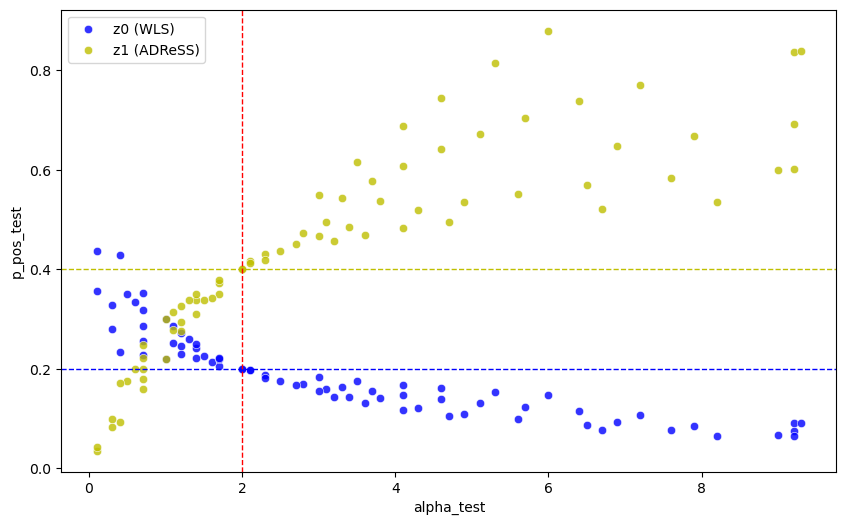

In [73]:
fig, ax = plt.subplots(figsize=(10,6))


sns.scatterplot(x="alpha_test", y="p_pos_test_z0", data=tmp[tmp['variable']==0], color="b", ax=ax, label="z0 (WLS)", alpha=0.8)
sns.scatterplot(x="alpha_test", y="p_pos_test_z1", data=tmp[tmp['variable']==0], color="y", ax=ax, label="z1 (ADReSS)", alpha=0.8)

ax.axhline(y=0.2, c="b", ls="--", linewidth=1)
ax.axhline(y=0.4, c="y", ls="--", linewidth=1)

ax.axvline(x=2, c="r", ls="--", linewidth=1)

ax.set_ylabel("p_pos_test")

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1
0,"(0.3, 0.6, 0.2, 1.4000000000000001, 4, 150, 0)",0,0.627622,0.2,1.4,0.333333,0.466667
1,"(0.3, 0.6, 0.2, 1.6, 4, 150, 0)",0,0.619494,0.2,1.6,0.321429,0.514286
2,"(0.3, 0.6, 0.2, 1.9000000000000001, 4, 150, 0)",0,0.608464,0.2,1.9,0.305085,0.579661
3,"(0.3, 0.6, 0.2, 2.0, 4, 150, 0)",0,0.625250,0.2,2.0,0.300000,0.600000
4,"(0.3, 0.6, 0.2, 2.6, 4, 150, 0)",0,0.613280,0.2,2.6,0.272727,0.709091
...,...,...,...,...,...,...,...
325,"(0.3, 0.6, 0.5, 4.7, 4, 150, 0)",4,0.585860,0.5,4.7,0.157895,0.742105
326,"(0.3, 0.6, 0.5, 5.9, 4, 150, 0)",4,0.581876,0.5,5.9,0.130435,0.769565
327,"(0.3, 0.6, 0.5, 6.6000000000000005, 4, 150, 0)",4,0.573532,0.5,6.6,0.118421,0.781579
328,"(0.3, 0.6, 0.5, 7.6000000000000005, 4, 150, 0)",4,0.601986,0.5,7.6,0.104651,0.795349


<Figure size 1200x1000 with 0 Axes>

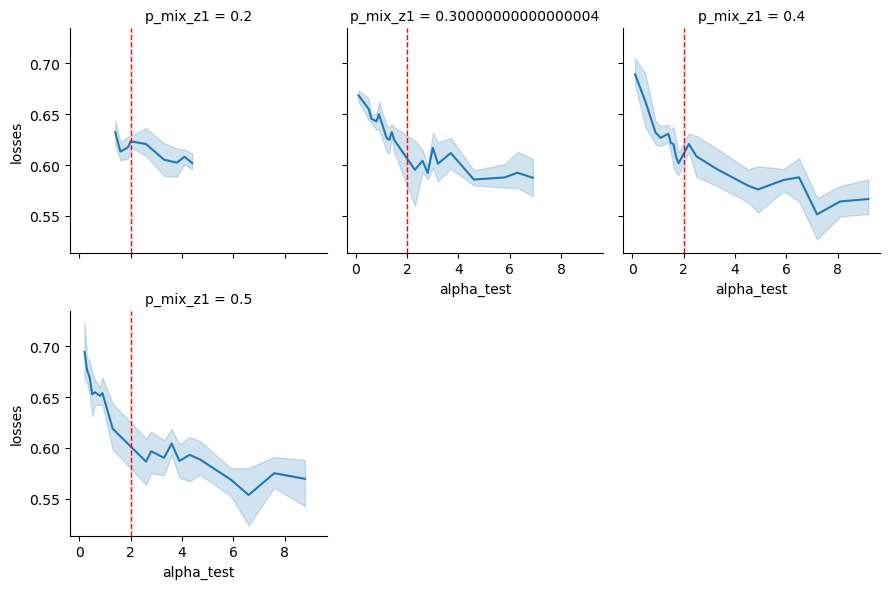

In [74]:
plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='losses')

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1
0,"(0.3, 0.6, 0.2, 1.4000000000000001, 4, 150, 0)",0,0.557043,0.2,1.4,0.333333,0.466667
1,"(0.3, 0.6, 0.2, 1.6, 4, 150, 0)",0,0.528892,0.2,1.6,0.321429,0.514286
2,"(0.3, 0.6, 0.2, 1.9000000000000001, 4, 150, 0)",0,0.562935,0.2,1.9,0.305085,0.579661
3,"(0.3, 0.6, 0.2, 2.0, 4, 150, 0)",0,0.506940,0.2,2.0,0.300000,0.600000
4,"(0.3, 0.6, 0.2, 2.6, 4, 150, 0)",0,0.539766,0.2,2.6,0.272727,0.709091
...,...,...,...,...,...,...,...
325,"(0.3, 0.6, 0.5, 4.7, 4, 150, 0)",4,0.792464,0.5,4.7,0.157895,0.742105
326,"(0.3, 0.6, 0.5, 5.9, 4, 150, 0)",4,0.830032,0.5,5.9,0.130435,0.769565
327,"(0.3, 0.6, 0.5, 6.6000000000000005, 4, 150, 0)",4,0.756865,0.5,6.6,0.118421,0.781579
328,"(0.3, 0.6, 0.5, 7.6000000000000005, 4, 150, 0)",4,0.785656,0.5,7.6,0.104651,0.795349


<Figure size 1200x1000 with 0 Axes>

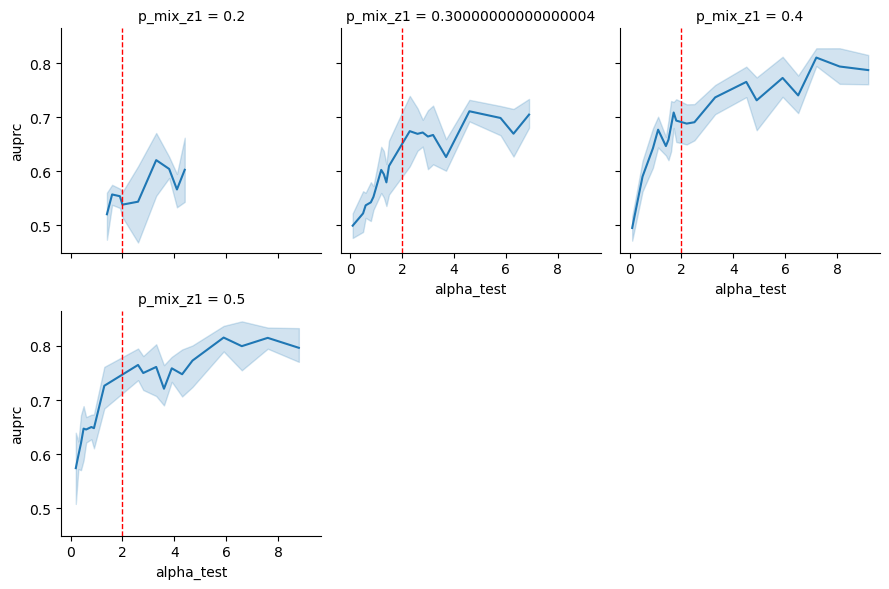

In [75]:
plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='auprc')

In [51]:
tmp = pd.DataFrame.from_dict({c:losses_dict['losses'][idx] for idx,c in enumerate(losses_dict['combination'])},
                             orient="index"
                            )
tmp = tmp.reset_index()

tmp = pd.melt(tmp, id_vars="index", value_vars=[0,1,2,3,4])

tmp = tmp.assign(p_mix_z1=np.array(list(tmp['index']))[:,2], alpha_test=np.array(list(tmp['index']))[:,3])



tmp['alpha_test'] = tmp['alpha_test'].round(1) # for
tmp['p_mix_z1'] = tmp['p_mix_z1'].round(1) # for

[Text(0, 0.5, 'Losses')]

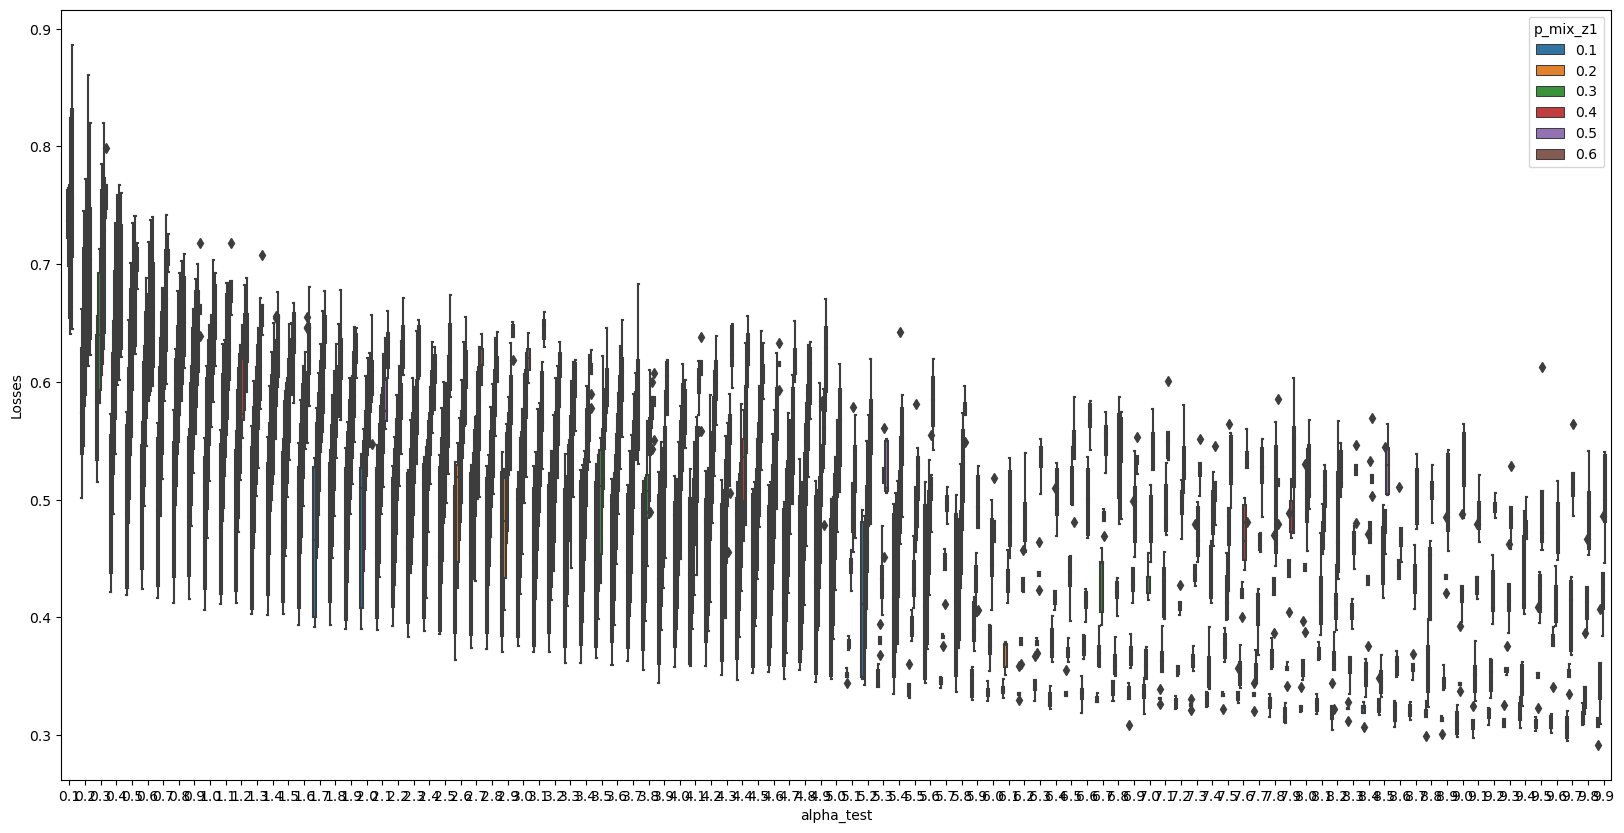

In [52]:


plt.figure(figsize=(20,10))
ax = sns.boxplot(x='alpha_test',y='value', 
            hue='p_mix_z1',
            data=tmp)
ax.set(ylabel="Losses")

In [298]:
np.array(losses_dict['combination'])[:,(2,3)]

array([[0.101, 1.   ],
       [0.101, 1.2  ],
       [0.101, 1.4  ],
       [0.201, 1.   ],
       [0.201, 1.2  ],
       [0.201, 1.4  ],
       [0.301, 1.   ],
       [0.301, 1.2  ],
       [0.301, 1.4  ],
       [0.401, 1.   ],
       [0.401, 1.2  ],
       [0.401, 1.4  ],
       [0.501, 1.   ],
       [0.501, 1.2  ],
       [0.501, 1.4  ],
       [0.601, 1.   ],
       [0.601, 1.2  ],
       [0.601, 1.4  ]])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5839d144f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5839d14bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5839d14190>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5839d1c2b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5839d1c610>],
 'means': []}

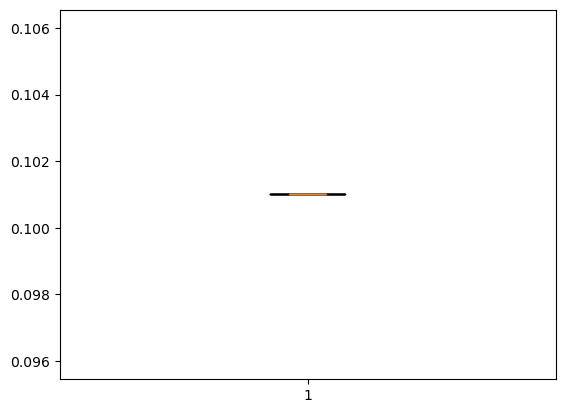

In [305]:
plt.boxplot(np.array(losses_dict['combination'])[:,2][:3],
            [losses_dict['losses'][0], losses_dict['losses'][1], losses_dict['losses'][2]])

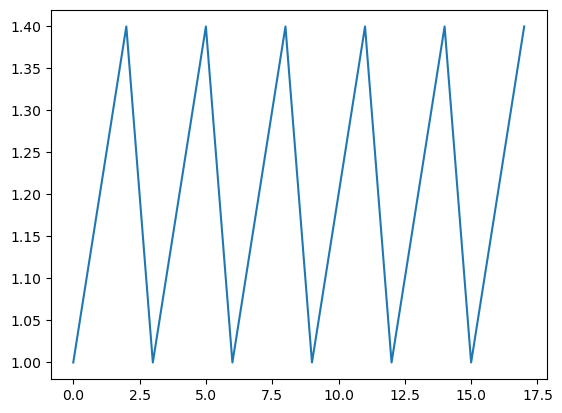

In [307]:

plt.plot(np.array(losses_dict['combination'])[:,3])

In [306]:
np.array(losses_dict['combination'])[:,2][:3]

array([0.101, 0.101, 0.101])